In [1]:
#!pip install backtrader

In [2]:
import pandas as pd
from datetime import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import backtrader as bt
import yfinance as yf
%matplotlib inline 
%matplotlib widget

In [3]:
data = yf.download('BTC-USD',start='2022-01-01')

[*********************100%***********************]  1 of 1 completed


In [4]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-01,46311.746094,47827.312500,46288.484375,47686.812500,47686.812500,24582667004
2022-01-02,47680.925781,47881.406250,46856.937500,47345.218750,47345.218750,27951569547
2022-01-03,47343.542969,47510.726562,45835.964844,46458.117188,46458.117188,33071628362
2022-01-04,46458.851562,47406.546875,45752.464844,45897.574219,45897.574219,42494677905
2022-01-05,45899.359375,46929.046875,42798.222656,43569.003906,43569.003906,36851084859
...,...,...,...,...,...,...
2023-01-14,19910.537109,21075.142578,19907.828125,20976.298828,20976.298828,38967784639
2023-01-15,20977.484375,20993.748047,20606.986328,20880.798828,20880.798828,19298407543
2023-01-16,20882.224609,21360.875000,20715.746094,21169.632812,21169.632812,26792494050


In [5]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.order = None
        
        self.sma = bt.ind.SMA(period=200)
        self.boll = bt.ind.BollingerBands(period=20, devfactor=2.5)
        self.rsi = bt.ind.RSI(period=2,safediv=True)
         self.ema = bt.ind.EMA(period=25)
    
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            #Buy/Sell order sumbitted/accepted to/by broker - Nothing to do 
            return

        
        #Check if an order has been completed
        #Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)
    
            self.bar_executed=len(self)
    
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        
        #Check if an order is pending..if yes, we cannot send a 2nd one
        if self.order:
            return
        
        #Check if we are in the market
        if not self.position:
            
            if self.data.close > self.sma and \
            self.data.close < self.boll.lines.bot:
                    # BUY, BUY, BUY!!! (with all possible default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])
                       
                    
                    #Keeps track of the created order to avoid a 2nd order
                        self.order = self.buy(exectype = bt.Order.Limit,
                                         price = 0.97 * self.dataclose[0])
                        
        else:
            
            
            # Already in the market...we might sell
            if self.rsi > 50 or len(self) >=(self.bar_executed + 10):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    
                #Keeps track of the created order to avoid a 2nd order
                self.order = self.sell()


In [6]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    # Create a Data Feed
    data = bt.feeds.PandasData(dataname=data)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000)
    
    cerebro.broker.setcommission(commission=0.005)
    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000.00
2022-07-19, Close, 23389.43
2022-07-20, Close, 23231.73
2022-07-21, Close, 23164.63
2022-07-22, Close, 22714.98
2022-07-23, Close, 22465.48
2022-07-24, Close, 22609.16
2022-07-25, Close, 21361.70
2022-07-26, Close, 21239.75
2022-07-27, Close, 22930.55
2022-07-28, Close, 23843.89
2022-07-29, Close, 23804.63
2022-07-30, Close, 23656.21
2022-07-31, Close, 23336.90
2022-08-01, Close, 23314.20
2022-08-02, Close, 22978.12
2022-08-03, Close, 22846.51
2022-08-04, Close, 22630.96
2022-08-05, Close, 23289.31
2022-08-06, Close, 22961.28
2022-08-07, Close, 23175.89
2022-08-08, Close, 23809.49
2022-08-09, Close, 23164.32
2022-08-10, Close, 23947.64
2022-08-11, Close, 23957.53
2022-08-12, Close, 24402.82
2022-08-13, Close, 24424.07
2022-08-14, Close, 24319.33
2022-08-15, Close, 24136.97
2022-08-16, Close, 23883.29
2022-08-17, Close, 23336.00
2022-08-18, Close, 23212.74
2022-08-19, Close, 20877.55
2022-08-20, Close, 21166.06
2022-08-21, Close, 21534.12
2022-08-22, Cl

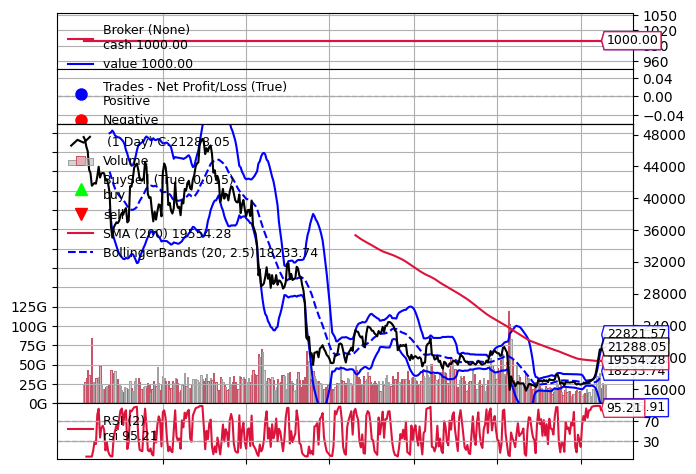

[[<Figure size 640x480 with 5 Axes>]]

In [10]:
%matplotlib inline
cerebro.plot(iplot = False)

In [8]:
#def getdata(symbol,start):
    #frame = pd.DataFrame(client.get_historical_klines(symbol,
                                                      #'1d',
                                                     # start))
#frame = frame.iloc[:,:6]
#frame.columns = ['Time','Open','High','Low','Close','Volume']
#frame.set_index('Time', inplace=True)
#frame.index = pd.to_datetime(frame,index,unit='ms')
#frame = frame.astype(float)
#return frame

In [9]:
#data = getdata('BTCUSDT','2022-01-01')